***This notebook is my way through the HuggingFace Diffusers Course***

# Introduction to Diffusers

## Step 1: Setup

In [1]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.2 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cudf 23.8.0 requires pyarrow==11.*, but you have pyarrow 9.0.0 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.9.0 which is incompatible.
dask-cudf 23.8.0 requires dask==2023.7.1

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

def make_grid(images, size=64):
    output_im = Image.new('RGB', (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
from diffusers import StableDiffusionPipeline

model_id = "sd-dreambooth-library/mr-potato-head"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


unet/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

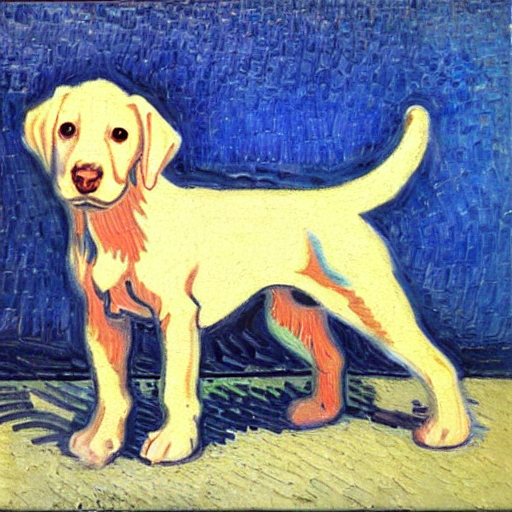

In [8]:
prompt = 'an abstract oil painting of a white labrador puppy by van gogh'
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

### Minimum Viable Pipeline (MVP)

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

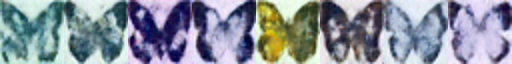

In [9]:
from diffusers import DDPMPipeline

butterfly_pipeline = DDPMPipeline.from_pretrained("johnowhitaker/ddpm-butterflies-32px").to(device)
images = butterfly_pipeline(batch_size=8).images
make_grid(images)

**Training Process of a Diffusion Model:**
1. Load in some images from the training data.
2. Add noise, in different amounts.
3. Feed the noisy versions of the inputs into the model.
4. Evaluate how well the model does at denoising these inputs.
5. Use this information to update the model weights, and repeat.

## Step 2: Download a Training Dataset

In [10]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

In [11]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split='train')
image_size = 32
batch_size = 64

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [12]:
def transform(examples):
    images = [preprocess(image.convert('RGB')) for image in examples['image']]
    return {'images': images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

X shape:  torch.Size([8, 3, 32, 32])


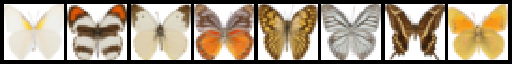

In [13]:
xb = next(iter(train_dataloader))['images'].to(device)[:8]
print("X shape: ", xb.shape)
show_images(xb).resize((8*64, 64), resample=Image.NEAREST)

## Step 3: Define the Scheduler

In [14]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

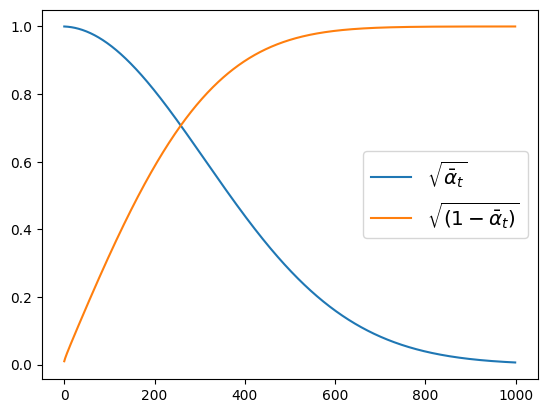

In [15]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

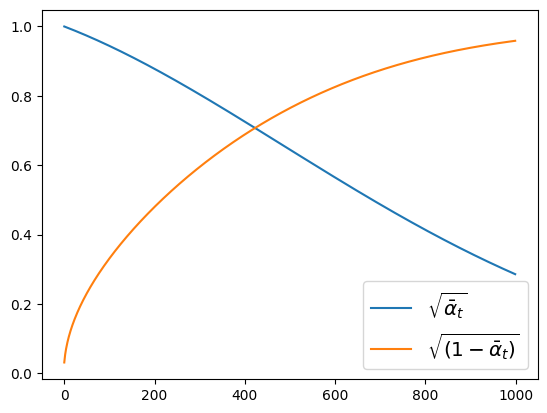

In [16]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

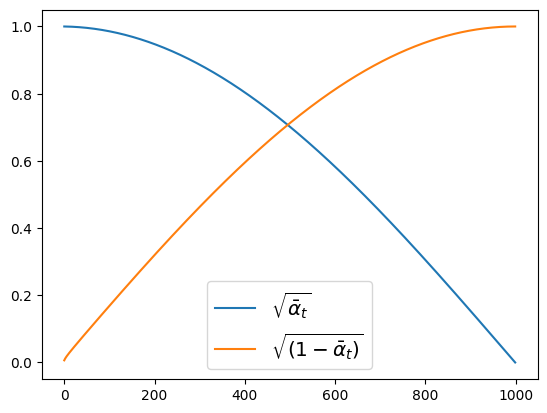

In [17]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Noisy X Shape torch.Size([8, 3, 32, 32])


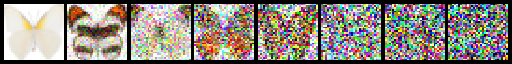

In [18]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X Shape", noisy_xb.shape)
show_images(noisy_xb).resize((8*64, 64), resample=Image.NEAREST)

## Step 4: Define the Model

### U-Net
In a Nutshell,
- the model has the input image go through several blocks of ResNet layers, each of which halves the images size by 2.
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downsample path to the corresponding layers in the upsample path.

In [19]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'AttnDownBlock2D'
    ),
    up_block_types=(
        'AttnUpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D'
    )
)

model.to(device);

In [20]:
with torch.no_grad():
    model_pred = model(noisy_xb, timesteps).sample
model_pred.shape

torch.Size([8, 3, 32, 32])

## Step 5: Create a Training Loop

In [21]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch['images'].to(device)
        
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]
        
        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
        
        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        
        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())
        
        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()
        
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch: {epoch+1}, Loss: {loss_last_epoch}")

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch: 5, Loss: 0.15810336219146848
Epoch: 10, Loss: 0.1266155787743628
Epoch: 15, Loss: 0.10313898511230946
Epoch: 20, Loss: 0.08977361395955086
Epoch: 25, Loss: 0.08332479884847999
Epoch: 30, Loss: 0.07356110657565296


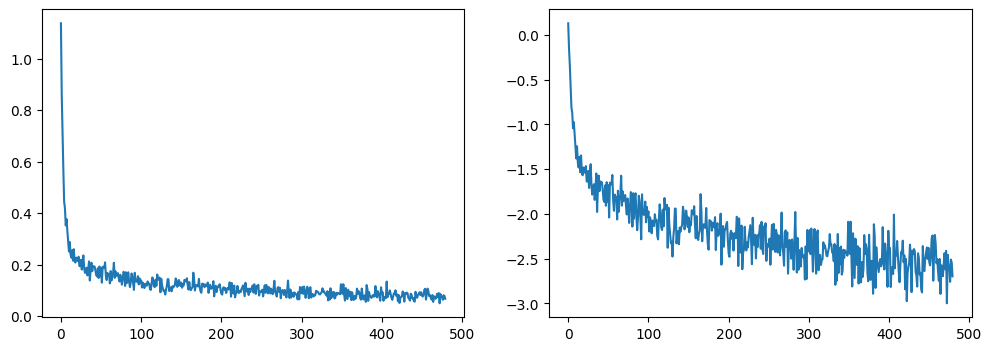

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Step 6: Generate Images

### Option 1: Creating a Pipeline

In [23]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

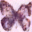

In [24]:
pipeline_output = image_pipe()
pipeline_output.images[0]

In [25]:
image_pipe.save_pretrained('my_pipeline')

In [26]:
!ls my_pipeline/

model_index.json  scheduler  unet


In [27]:
!ls my_pipeline/unet

config.json  diffusion_pytorch_model.safetensors


### Option 2: Writing a Sampling Loop

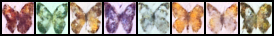

In [28]:
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = model(sample, t).sample
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

## Step 7: Push your model to the Hub

In [29]:
from huggingface_hub import notebook_login
notebook_login()

In [30]:
from huggingface_hub import get_full_repo_name

model_name = 'sd-class-butterflies-32'
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'ubermenchh/sd-class-butterflies-32'

In [31]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path='my_pipeline/scheduler', path_in_repo='', repo_id=hub_model_id)
api.upload_folder(folder_path='my_pipeline/unet', path_in_repo='', repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj='my_pipeline/model_index.json',
    path_in_repo='model_index.json',
    repo_id=hub_model_id
)

HfHubHTTPError: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-65424d24-5428d49f1f82ff8a59fe7aca;242c4c4f-10cc-4f00-a3e3-e4cc49f98d15)

You already created this model repo

In [38]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/ubermenchh/sd-class-butterflies-32/blob/main/README.md'

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

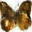

In [40]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]

## Scaling up with HuggingFace Accelerate

In [41]:
!wget https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py

--2023-11-01 12:45:53--  https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/huggingface/diffusers/main/examples/unconditional_image_generation/train_unconditional.py [following]
--2023-11-01 12:45:53--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/unconditional_image_generation/train_unconditional.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29768 (29K) [text/plain]
Saving to: ‘train_unconditional.py’

train_unconditional 100%[===================>]  29.07K 

In [47]:
model_name = 'sd-class-butterflies-64'
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'ubermenchh/sd-class-butterflies-64'

In [45]:
!accelerate launch train_unconditional.py \
  --dataset_name="huggan/smithsonian_butterflies_subset" \
  --resolution=64 \
  --output_dir={model_name} \
  --train_batch_size=32 \
  --num_epochs=50 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_warmup_steps=500 \
  --mixed_precision="no"

Traceback (most recent call last):
  File "/kaggle/working/train_unconditional.py", line 32, in <module>
    check_min_version("0.22.0.dev0")
  File "/opt/conda/lib/python3.10/site-packages/diffusers/utils/__init__.py", line 101, in check_min_version
    raise ImportError(error_message)
ImportError: This example requires a source install from HuggingFace diffusers (see `https://huggingface.co/docs/diffusers/installation#install-from-source`), but the version found is 0.21.4.

Traceback (most recent call last):
  File "/opt/conda/bin/accelerate", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/accelerate/commands/accelerate_cli.py", line 47, in main
    args.func(args)
  File "/opt/conda/lib/python3.10/site-packages/accelerate/commands/launch.py", line 994, in launch_command
    simple_launcher(args)
  File "/opt/conda/lib/python3.10/site-packages/accelerate/commands/launch.py", line 636, in simple_launcher
    raise subprocess.CalledProcessError

In [48]:
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path=f'{model_name}/scheduler', path_in_repo='', repo_id=hub_model_id)
api.upload_folder(folder_path=f'{model_name}/unet', path_in_repo='', repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj=f"{model_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id
)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

HfHubHTTPError: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-65424a22-5266ba0e75302bee1af5b44f;f5eac5dd-3cd7-4332-9de7-dd2067e3f8ba)

You already created this model repo